In [1]:
import requests

import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import shape

from google.oauth2 import service_account
from google.cloud import bigquery

from lets_plot.plot import *

# Getting started with BigQuery GIS #
Remake of the example https://cloud.google.com/bigquery/docs/gis-getting-started with lets_plot library

In [2]:
NYC_DISTRICT_IDS = [9691750, 8398124, 9691819, 9691948, 9691916]
NYC_XMIN, NYC_XMAX, NYC_YMIN, NYC_YMAX = -74.05, -73.9, 40.65, 40.85

In [3]:
def osm_boundaries(osm_id):
    response = requests.get('http://polygons.openstreetmap.fr/get_geojson.py?id={0}&params=0'.format(osm_id))
    return gpd.GeoDataFrame(geometry=[ shape(response.json()['geometries'][0]) ])

In [4]:
credentials = service_account.Credentials.from_service_account_file(
    'bigquery_account_credentials.json',
    scopes=['https://www.googleapis.com/auth/cloud-platform'],
)
client = bigquery.Client(credentials=credentials, project=credentials.project_id)
query_job = client.query('''
    SELECT ST_GeogPoint(longitude, latitude) as WKT, num_bikes_available
    FROM `bigquery-public-data.new_york.citibike_stations`
    WHERE num_bikes_available > 30
''')

In [5]:
df = query_job.result().to_dataframe()
df['WKT'] = df['WKT'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='WKT')

In [6]:
nyc_gdf = pd.concat([osm_boundaries(osm_id) for osm_id in NYC_DISTRICT_IDS])


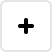
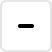
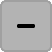
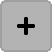
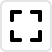
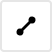
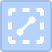

In [7]:
ggplot() + \
    geom_rect(xmin=NYC_XMIN, xmax=NYC_XMAX, ymin=NYC_YMIN, ymax=NYC_YMAX, fill='#deebf7') + \
    geom_polygon(data=nyc_gdf, color='#3182bd', fill='#f1f1f1') + \
    geom_point(aes(size='num_bikes_available'), data=gdf, color='#0000FF', alpha=.5) + \
    scale_size(range=[4, 8], name='Available bikes') + \
    coord_cartesian(xlim=[NYC_XMIN, NYC_XMAX], ylim=[NYC_YMIN, NYC_YMAX]) + \
    theme(axis_title='blank', axis_text='blank', axis_ticks='blank', axis_line='blank') + \
    ggsize(800, 600)